In [298]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [299]:
dataset = 'datasets/keypoint1000.csv'
model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier.tflite'

# Set number of classes

In [300]:
NUM_CLASSES = 12
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 

# Dataset reading

In [301]:
def apply_rotation(label, points):
    num_points = 21
    point_0 = points[0]
    point_8 = points[8]

    if label == 'dislike' or label == 'like':
        return points  # No rotation
    elif label == 'call':
        # Rotate to be parallel with X-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[0])  # Consider the X-Z plane
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle), -np.sin(angle)],
            [0, np.sin(angle), np.cos(angle)]
        ])
    else:
        # Rotate to be parallel with Y-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[1])  # Consider the Y-Z plane
        rotation_matrix = np.array([
            [np.cos(angle), 0, np.sin(angle)],
            [0, 1, 0],
            [-np.sin(angle), 0, np.cos(angle)]
        ])
    
    # Apply rotation
    for i in range(num_points):
        points[i] = np.dot(rotation_matrix, points[i])

    return points


In [302]:
def pre_process_dataset(X_dataset, y_dataset):
    # Reshape to 3D
    num_points = 21
    reshaped_dataset = X_dataset.reshape(-1, num_points, 3)

    # Shift coordinates
    for i in range(len(reshaped_dataset)):
        base_point = reshaped_dataset[i, 0]  # ID:0
        for j in range(num_points):
            reshaped_dataset[i, j] -= base_point

    # Rotation
    for i in range(len(reshaped_dataset)):
        label = LABELS[y_dataset[i]]
        reshaped_dataset[i] = apply_rotation(label, reshaped_dataset[i])

    # Flatten
    flattened_dataset = reshaped_dataset.reshape(-1, num_points * 3)

    # Normalization
    max_abs_value = np.max(np.abs(flattened_dataset))
    normalized_dataset = flattened_dataset / max_abs_value

    return normalized_dataset

In [303]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [304]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [305]:
X_dataset_preprocessed = pre_process_dataset(X_dataset, y_dataset)

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_preprocessed, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [307]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [308]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_22 (Dropout)        (None, 63)                0         
                                                                 
 dense_58 (Dense)            (None, 128)               8192      
                                                                 
 batch_normalization_21 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_22 (Bat  (None, 128)              512       
 chNormalization)                                    

In [309]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [310]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [311]:
es_callback

In [312]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


62/71 [=========================>....] - ETA: 0s - loss: 2.2971 - accuracy: 0.2082
Epoch 1: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 1s 7ms/step - loss: 2.2604 - accuracy: 0.2222 - val_loss: 2.3756 - val_accuracy: 0.1723
Epoch 2/1000
70/71 [============================>.] - ETA: 0s - loss: 1.7975 - accuracy: 0.3738
Epoch 2: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 1.7979 - accuracy: 0.3736 - val_loss: 2.1992 - val_accuracy: 0.2097
Epoch 3/1000
56/71 [======================>.......] - ETA: 0s - loss: 1.6348 - accuracy: 0.4255
Epoch 3: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 1.6209 - accuracy: 0.4302 - val_loss: 1.8624 - val_accuracy: 0.3290
Epoch 4/1000
57/71 [=======================>......] - ETA: 0s - loss: 1.5196 - accuracy: 0.4688
Epoch 4: saving model to models\keypoint_classifier.hdf5
71/71 [=======

In [313]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/24 [>.............................] - ETA: 0s - loss: 0.1334 - accuracy: 0.9375

24/24 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9287


In [314]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [315]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 72ms/step
[4.5524525e-11 9.9999905e-01 1.2392433e-12 9.2140350e-17 1.2869642e-11
 1.0778308e-07 3.5136797e-14 8.7989827e-07 4.2086065e-10 2.1150603e-08
 3.4840337e-08 8.4580023e-09]
1


# Integrate with secondary model

In [316]:
# Determine the index of 'stop' and 'palm'
label_stop = LABELS.index('stop')
label_palm = LABELS.index('palm')

# Filter out samples for 'stop' and 'palm'
secondary_X = X_dataset_preprocessed[np.logical_or(y_dataset == label_stop, y_dataset == label_palm)]
secondary_y = y_dataset[np.logical_or(y_dataset == label_stop, y_dataset == label_palm)]

# Create binary labels (0 and 1) for 'stop' and 'palm'
secondary_y = np.where(secondary_y == label_stop, 0, 1)  # Set 'stop' to 0, 'palm' to 1

# Split secondary data sets
X_train_secondary, X_test_secondary, y_train_secondary, y_test_secondary = train_test_split(
    secondary_X, secondary_y, train_size=0.75, random_state=RANDOM_SEED
)

In [317]:
# Build a secondary classifier
secondary_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_secondary.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Binary classification
])

# Compile secondary model
secondary_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train a secondary model
secondary_model.fit(X_train_secondary, y_train_secondary, epochs=100, batch_size=32, validation_data=(X_test_secondary, y_test_secondary))


Epoch 1/100
47/47 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.4867 - val_loss: 0.6909 - val_accuracy: 0.5080
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5520 - val_loss: 0.6926 - val_accuracy: 0.5100
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6872 - accuracy: 0.5407 - val_loss: 0.6843 - val_accuracy: 0.5140
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.5973 - val_loss: 0.6790 - val_accuracy: 0.5940
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6762 - accuracy: 0.6073 - val_loss: 0.6737 - val_accuracy: 0.5740
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.6447 - val_loss: 0.6644 - val_accuracy: 0.6240
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6590 - accuracy: 0.6500 - val_loss: 0.6540 - val_accuracy: 0.6500
Epoch 8/100
4

In [318]:
def integrated_prediction(primary_model, secondary_model, input_data, threshold=0.5):
    primary_pred = primary_model.predict(input_data)
    primary_label = np.argmax(primary_pred, axis=1)
    
    # For samples predicted as 'stop' or 'palm' by the primary model, use the secondary model for judgment.
    secondary_indices = np.logical_or(primary_label == label_stop, primary_label == label_palm)
    secondary_pred = secondary_model.predict(input_data[secondary_indices])
    secondary_label = np.argmax(secondary_pred, axis=1)

    # Update predictions from the main model
    primary_label[secondary_indices] = np.where(secondary_label == 0, label_stop, label_palm)
    
    return primary_label

# Confusion matrix

 1/94 [..............................] - ETA: 1s

16/16 [==============================] - 0s 857us/step


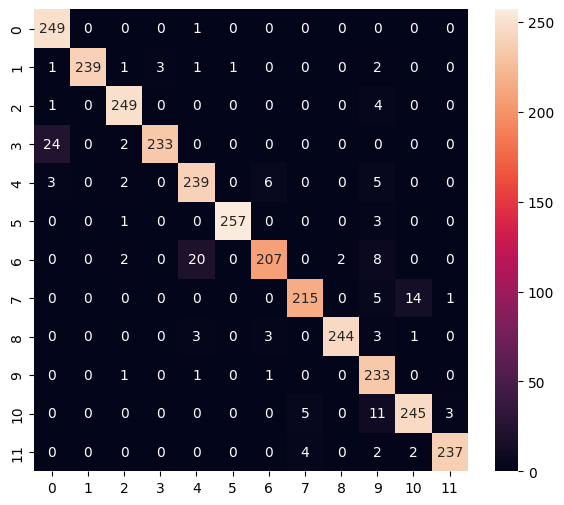

Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       250
           1       1.00      0.96      0.98       248
           2       0.97      0.98      0.97       254
           3       0.99      0.90      0.94       259
           4       0.90      0.94      0.92       255
           5       1.00      0.98      0.99       261
           6       0.95      0.87      0.91       239
           7       0.96      0.91      0.94       235
           8       0.99      0.96      0.98       254
           9       0.84      0.99      0.91       236
          10       0.94      0.93      0.93       264
          11       0.98      0.97      0.98       245

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [319]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

# Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)

y_pred = integrated_prediction(model, secondary_model, X_test)  # Integrated prediction

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [320]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [321]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmpdf9fscr6\assets


INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmpdf9fscr6\assets


40424

In [ ]:
# Save secondary model

secondary_model.save(model_save_path, include_optimizer=False)

# Inference test

In [322]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [323]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [324]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [325]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [326]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5827551e-09 9.9999666e-01 8.3822775e-12 3.7934476e-15 5.4785843e-10
 1.6456488e-08 1.2740502e-12 1.9113163e-06 1.4874765e-09 8.2247340e-07
 3.6780801e-07 2.7632137e-07]
1
